# Лекция 3. Построение Redis Cluster

- Общее описание Redis Cluster. 
- Развертывание Redis кластера.
- Восстановление после сбоя, шардирование, добавление нового узла, удаление узла, миграция реплик.
- Установка и настройка Docker, настройка Redis на образе Docker

## Общее описание Redis Cluster.  Развертывание Redis кластера.

Redis может работать в двух режимах - в режиме отдельного сервера и в режиме кластера:

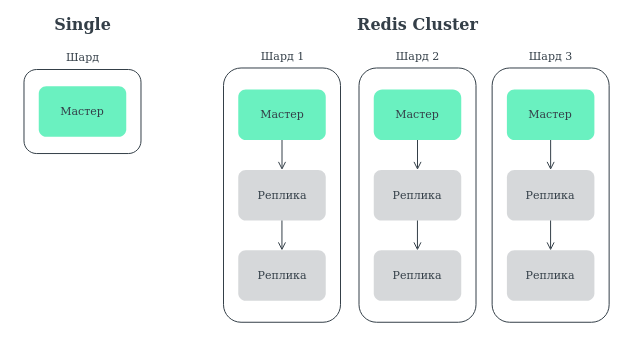

Одно из важных направлений использования Redis - это создание кластеров для обеспечения горизонтального масштабирования. Масштабирование реализуется путем разбиения единого сегмента данных на кластеры. Кластеризация используется не только для снижения нагрузки на сервер, но и для повышения отказоустойчивости за счет реализации репликации и шардирования. 

Стандартная технология масштабирования, которая используется в Redis, базируется на идее master - slave (ведущий-ведомый).

Причем master отвечает за запись в хранилище, slave обеспечивает только чтение. Свежие данные от master постепенно реплицируются на slave, поэтому надежного обеспечения целостности данных Redis не дает. Redis может обеспечивать также мультирепликацию, при которой существует несколько master серверов, синхронизирующихся друг с другом.

Также Redis обеспечивает шардирование - логическое разбиение данных на части, каждая из которых хранится на разных компьютерах. Например, шардирование реляционной таблицы заключается в хранении разных строк этой таблицы (а возможно и значений отдельных столбцов внутри одной строки) на разных компьютерах.

Redis Cluster состоит из шардов, каждый из которых содержит мастер-узел и набор реплик. Количество шардов и реплик задается при создании кластера. Минимальное количество шардов — три. Максимум можно добавить до восьми шардов и до восьми реплик на шард.

Redis Cluster использует формат шардирования, при котором каждый ключ концептуально является частью так называемого **хеш-слота (hash slot)**.

Всего в Redis 16384 хеш-слота. 

Каждый узел в кластере Redis отвечает за подмножество хеш-слотов, поэтому, например, у вас может быть кластер с 3 узлами, где:

Узел A содержит хеш-слоты от 0 до 5500.

Узел B содержит хеш-слоты с 5501 по 11000.

Узел C содержит хеш-слоты с 11001 по 16383.

Все эти 16384 хеш-слота распределяются между узлами кластера. Это позволяет легко добавлять и удалять узлы. Например, если в кластер из трех узлов A, B и C вы хотите добавить узел D, нужно переместить часть хеш-слотов с узлов A, B и C на узел D. А если вы хотите удалить узел A, нужно переместить хеш-слоты с узла A на остальные узлы. После этого можно удалить пустой узел A из кластера.

Перемещение хеш-слотов с одного узла на другой не влияет на выполнение операций и не требует остановки работы кластера.

Если в кластере из трех мастер-узлов A, B, C и их реплик A1, B1, C1 выйдет из строя мастер-узел B, реплика B1 возьмет на себя роль мастера. В этом случае кластер продолжит функционировать. Однако, если одновременно откажут B и B1, весь Redis Cluster выйдет из строя, потому что хеш-слоты, которые располагались на узле B, будут недоступны.

Redis Cluster не гарантирует полной сохранности данных. При определенных обстоятельствах могут быть утеряны подтвержденные операции записи.

При создании кластера необходимо запустить и настроить несколько Redis серверов. Каждый такой сервер должен слушать два порта. Первый порт обеспечивает обмен данными между сервером сегмента данных и клиентом, такой порт называется **клиентским**, по умолчанию он ассоциирован с числом 6379.


Второй порт называется **портом кластерной шины**, который обеспечивает обмен данным между различными узлами в кластере. Обычно номер такого порта определяется как номер клиентского порта плюс 10000, т.е. по умолчанию 16379.



## Развертывание Redis кластера.

В документации Redis cluster https://redis.io/topics/cluster-tutorial рекомендуется использовать как минимум три узла. 

Рассмотрим работу redis cluster на трех узлах master, и трех узлах slave. Назначим им клиентские порты: 7000, 7001, 7002, 7003, 7004, 7005. Под каждый узел создадим свои директории, внутри которых создадим конфигурационный файл redis.conf:

port 7000

cluster-enabled yes

cluster-config-file nodes.conf

cluster-node-timeout 5000

appendonly yes

Аналогичные конфигурационные файлы следует написать под другие порты, после чего следует запустить шесть сереров, каждый со своим конфигурационным файлом:

> redis-server /7000/redis.conf

> redis-server /7001/redis.conf

> redis-server /7002/redis.conf

> redis-server /7003/redis.conf

> redis-server /7004/redis.conf

> redis-server /7005/redis.conf

Внутри каждого каталога нужно запустить свой экземпляр redis-server

После запуска серверов, в каждом рабочем каталоге будет создан файл nodes.conf, указанный в конфигурационном файле. В nodes.conf хранится конфигурация для этого узла (другие узлы, их состояние, глобальные переменные и прочее.), этот файл нет смысла менять в ручную; он просто генерируется экземплярами Redis Cluster при запуске и обновляется каждый раз, когда это необходимо. 

Если посмотреть содержимой файла nodes.conf, то но содержит для каждого узла его уникальный идентификатор. Выглядит это примерно так:

5445093ebedbc7a7d121ae803edca725909b47e0 :0@0 myself,master - 0 0 0 connected
vars currentEpoch 0 lastVoteEpoch 0

Этот идентификатор будет использоваться этим конкретным экземпляром навсегда, чтобы у экземпляра было уникальное имя в контексте кластера. Каждый узел запоминает все остальные узлы, используя эти идентификаторы, а не  IP или порт. IP-адреса и порты могут меняться, но уникальный идентификатор узла никогда не изменится на протяжении всей жизни узла. Этот идентификатор называется **Node ID**.



Сам режим кластера включается директивой  **cluster-enabled yes**.

**cluster-node-timeout** - максимальное время, которое master-узел может быть недоступен, по истечению этого времени он помечается как нерабочий и slaves начинают его аварийное переключение.

**appendonly** - это свойство, при котором новые данные могут добавляться к хранилищу, но при этом существующие данные неизменяемы.

Указанные конфигурационные файлы обеспечивают минимальную функциональность, кроме этого могут использоваться и другие параметры:

**cluster-slave-validity-factor** - это число умноженное на таймаут узла - максимальное время, через которое slave начнет аварийное переключение.

**cluster-migration-barrier** - минимальное количество slaves master-а.

**cluster-require-full-coverage <yes/no>** - если для этого параметра установлено значение «да», как по умолчанию, кластер перестает принимать записи, если какой-то процент пространства ключей не покрыт каким-либо узлом. Если для параметра установлено значение «нет», кластер по-прежнему будет обслуживать запросы, даже если могут быть обработаны только запросы о подмножестве ключей.


После того, как запущены отдельные сервера кластера, можно приступить к созданию самого кластера. Это делается следующей командой:

redis-cli --cluster create 127.0.0.1:7000 127.0.0.1:7001 127.0.0.1:7002 127.0.0.1:7003 127.0.0.1:7004 127.0.0.1:7005 --cluster-replicas 1

Здесь используется команда create , так как мы хотим создать новый кластер. Опция --cluster-replicas 1 означает, что нам нужен один slave для каждого созданного мастера. Другие аргументы — это список адресов экземпляров, которые следует использовать для создания нового кластера.

Очевидно, что единственной установкой, соответствующей нашим требованиям, является создание кластера с 3 мастерами и 3 репликами.

M: b3d554f7ffb0a51159bfb28d2163e1127ca72e89 127.0.0.1:7000
   slots:[0-5460] (5461 slots) master
M: 67aa5a47396a7971991ef072361a4d256128bcd8 127.0.0.1:7001
   slots:[5461-10922] (5462 slots) master
M: 5445093ebedbc7a7d121ae803edca725909b47e0 127.0.0.1:7002
   slots:[10923-16383] (5461 slots) master
S: f992ae0a32a488218fa01636ee64b99a9ea4ee6f 127.0.0.1:7003
   replicates 67aa5a47396a7971991ef072361a4d256128bcd8
S: f8a9bb5a995f60ad96983966a46ced8f45799fc1 127.0.0.1:7004
   replicates 5445093ebedbc7a7d121ae803edca725909b47e0
S: 2b2ce06ea1284e46689fcdd80d287bc50afc1f54 127.0.0.1:7005
   replicates b3d554f7ffb0a51159bfb28d2163e1127ca72e89

Redis-cli предложит конфигурацию, которую следует принять, набрав yes . Кластер будет настроен и присоединен , что означает, что экземпляры будут загружены для общения друг с другом.

С полученным кластером можно работать с использованием redis-cli:

> redis-cli -c -p 7000

Ключ -c подключает режим кластеризации данных. После этого становятся доступны все ранее рассмотренные команды redis. При этом кластер сам перераспределяет хранение данных по узлам.
<img src="ris1.jpeg">

Как видно из рисунка, redis сам определяет, где и как хранить те, или иные значения ключей, систематически перераспределяя и реплицируя их хранение.

Для работы с Redis Cluster из python необходимо ставить библиотеку redis-py-cluster:

> pip3 install redis-py-cluster

В качестве примера создадим небольшой скрипт, который добавляет 1000 случайных пар - ключ: значение.

import uuid, rediscluster,random

r=rediscluster.RedisCluster(host='localhost',port=7000)

for i in range(1000):
  r.set(str(uuid.uuid4().hex),str(random.randint(1,1000000)))

После этого с помощью команды keys * можно увидеть, как перераспределилось хранение ключей между узлами кластера.

## Восстановление после сбоя, шардирование, добавление нового узла, удаление узла, миграция реплик

### Восстановление после сбоя

Чтобы посмотреть все узлы (ноды) кластера, можно использовать следующую команду:

> redis-cli -p 7000 cluster nodes

<img src="ris2.jpeg">

Вывод команды CLUSTER NODES включает в себя:

- Идентификатор узла;
- IP:порт;
- флаги: мастер, реплика, сам, сбой, ...
- если это реплика, Node ID мастера
- Время последнего отложенного PING, все еще ожидающего ответа.
- Время последнего полученного PONG.
- Эпоха конфигурации для данного узла.
- Статус ссылки на этот узел.
- Слоты, которые обслуживаются.

Попробуем выполнить аварийный останов одного из узлов

> redis-cli -p 7000 debug segfault

После этого мы получим автоматическую перенастройку системы:

<img src="ris3.jpeg">

Как видно из рисунка, узел порта 7000 находится в fail - сбое. Его функцию на себя взяла нода на порте 7005.

Мы можем попытаться восстановить узел 7000, для этих целей опять перезапускает сервер на порту 7000:

> ./redis-server /7000/redis.conf

После успешной настройки, можно увидеть, что теперь узел 7000 заработал в режиме slave:
<img src="ris4.jpeg">

### Шардирование

Сейчас данные на наших узлах хранятся так, как захотел redis. Однако, находясь на конкретном узле, мы можем потребовать, чтобы он знал больше, а не обращался за помощью к другим узлам. Для этого нужно выполнить операцию **решардинга**  - перемещение хеш-слотов из набора узлов в другой набор узлов.

Для этих целей нужно выполнить следующую команду (в команде достаточно указать только порт одного узла, остальные будут найдены автоматически):

> redis-cli --cluster reshard 127.0.0.1:7000

После этого нас спросят, как много слотов мы хотим перешардить:
    
    How many slots do you want to move (from 1 to 16384)?
    
Здесь нужно указать число из заданного диапазона.

Следующим вопросом будет:

What is the receiving node ID? (Какой идентификатор у принимающего узла?). Здесь мы должны указать  Node ID, который является мастером.

Следующим вопросом будет - с каких узлов вы хотите взять эти ключи. Здесь можно набрать all, чтобы взять немного хеш-слотов со всех других мастер-узлов.

После окончательного подтверждения вы увидите сообщение для каждого слота о том, что redis-cli собирается переместиться с узла на другой, и точка будет напечатана для каждого фактического ключа, перемещенного с одной стороны на другую.

После подтверждения этого действия все хеш-слоты из заданного диапазона будут шардированы на заданных узел.

Можно посмотреть, сколько хеш-слотов шардировано на заданный узел:

> redis-cli --cluster check 127.0.0.1:7005

### Добавление нового узла

Также в кластер можно добавить новый узел. Добавление нового узла — это, по сути, процесс добавления пустого узла, а затем перемещения в него некоторых данных, если это новый мастер, или указание настроить его как реплику известного узла, если это slave.


В обоих случаях первым шагом является добавление пустого узла .

Это так же просто, как запустить новый узел в порту 7006 (мы уже использовали от 7000 до 7005 для наших существующих 6 узлов) с той же конфигурацией, что и для других узлов, за исключением номера порта.

После создания нового сервера, например на порту 7006, его нужно запустить.


Теперь мы можем использовать redis-cli как обычно, чтобы добавить узел в существующий кластер.

> redis-cli --cluster add-node 127.0.0.1:7006 127.0.0.1:7000

Как видно, использована команда add-node, для которой указан адрес нового узла в качестве первого аргумента и адрес случайного существующего узла в кластере в качестве второго аргумента.

Теперь можно подключиться к новой ноде и увидеть, что она включена в кластер:

> redis-cli -c -p 7006
> cluster nodes

<img src="ris5.jpeg">

Как видно, данный узел стал master, однако у него есть особенность - он не содержит данных, поскольку ему не назначены хеш-слоты, он не участвует в процессе выбора, когда slave хочет стать мастером.

Теперь этому узлу можно назначать хеш-слоты, используя функцию перешардинга redis-cli.

Для добавления нового узла в качестве slave, нужно использовать туже команду с параметром --cluster-slave:

> redis-cli --cluster add-node 127.0.0.1:7007 127.0.0.1:7000 --cluster-slave

Посмотреть ноды кластера можно опять с помощью команды:

> redis-cli -p 7000 cluster nodes

<img src="ris6.jpeg">

### Удаление узла

Чтобы удалить узел slave, можно использовать команду  del-node redis-cli:
    
> redis-cli --cluster del-node 127.0.0.1:7000 <node-id>

Первый аргумент — это просто случайный узел в кластере, второй аргумент — это идентификатор узла, который требуется удалить.

Таким же образом можно удалить главный узел (master), однако для удаления главного узла он должен быть пустым . Если мастер не пуст, нужно перед этим перенаправить данные с него на все остальные мастер-ноды.

### Миграция реплик

В Redis Cluster можно в любое время перенастроить реплику для репликации с другим мастером, просто используя следующую команду:

CLUSTER REPLICATE <master-node-id>
    
<img src="ris7.jpeg">

Для повышения надежности системы у нас есть возможность добавлять дополнительные реплики к каждому мастеру, но это дорого. Миграция реплик позволяет добавить больше реплик всего к нескольким мастерам. Например, у вас есть 10 мастеров с 1 репликой на каждом, всего 20 экземпляров. Однако вы добавляете, например, еще 3 экземпляра в качестве реплик некоторых из ваших мастеров, поэтому у некоторых мастеров будет более одной реплики.

При переносе реплик происходит следующее: если мастер остается без реплик, реплика с мастера, имеющего несколько реплик, переносится на осиротевший мастер.

## Установка и настройка Docker, настройка Redis на образе Docker

Для тестирования Redis удобно использовать контейнер приложений docker. Это очень похоже на виртуальную машину, но по факту намного легковеснее.

Docker — это приложение, упрощающее процесс управления процессами приложения в контейнерах. Контейнеры позволяют запускать приложения в процессах с изолированными ресурсами. Они похожи на виртуальные машины, но более портативные, более эффективно расходуют ресурсы и в большей степени зависят от операционной системы хоста.

Для установки docker в окружении Ubuntu можно выполнить следующий ряд команд:
    
Обновляемся из репозиториев:
    
    > sudo apt update
    
Установливаем несколько необходимых пакетов, которые позволяют apt использовать пакеты через HTTP:
    
    > sudo apt install apt-transport-https ca-certificates curl software-properties-common
    
Добавляем ключ для официального репозитория Docker в нашу систему:
    
    > curl -fsSL https://download.docker.com/linux/ubuntu/gpg | sudo apt-key add -
    
Добавляем репозиторий Docker в источники APT:

> sudo add-apt-repository "deb [arch=amd64] https://download.docker.com/linux/ubuntu focal stable"

Обновляемся:
    
> sudo apt update

Устанавливаем Docker:
    
> sudo apt install docker-ce

Docker должен быть установлен, демон-процесс запущен, а для процесса активирован запуск при загрузке. 

Можно проверить, что он запущен:

> sudo systemctl status docker

По умолчанию команда docker может быть запущена только пользователем root.

Контейнеры Docker получают из образов Docker. По умолчанию Docker загружает эти образы из Docker Hub, реестр Docker, контролируемые Docker, т.е. компанией, реализующей проект Docker. Любой может размещать свои образы Docker на Docker Hub, поэтому большинство приложений и дистрибутивов Linux, которые вам потребуется, хранят там свои образы.

Можно выполнить поиск доступных на Docker Hub образов с помощью команды search. Например, чтобы найти образ Ubuntu:

> docker search ubuntu

Запустите следующую команду, чтобы загрузить официальный образ ubuntu на свой компьютер:

> docker pull ubuntu

После того как образ будет загружен, вы сможете запустить контейнер с помощью загруженного образа с помощью субкоманды run. В качестве примера мы запустим контейнер с самым последним образом образ Ubuntu. Сочетание переключателей -i и -t предоставляет вам доступ к интерактивной командной оболочке внутри контейнера:

> docker run -it ubuntu

Чтобы просмотреть образы, которые были загружены на ваш компьютер, можно ввести:

> docker images

Чтобы посмотреть список запущенных и неактивных контейнеров, можно использовать команду:

> docker ps -a


<img src="ris8.jpeg">


Чтобы запустить остановленный контейнер, воспользуйтесь docker start с идентификатором контейнера или именем контейнера. Давайте запустим контейнер на базе Ubuntu с идентификатором:

> docker start ad81da227226

Чтобы остановить запущенный контейнер, используйте docker stop с идентификатором или именем контейнера. 

> docker stop ad81da227226

После того как вы решили, что вам больше не потребуется контейнер, удалите его с помощью команды docker rm, снова добавив идентификатор контейнера или его имя.

> docker rm ad81da227226

После запуска контейнера Вы имеете полный доступ к Ubuntu из командной строки, реализуя стандартные способы установки программного обеспечения, в том числе и redis.